# Testing the model GRU Predictive Model

In [1]:
# @Author: Gebremichael
# @File: dialogic_ADPCM.py 
import wave
import numpy as np

# table of index
IndexTable = [-1, -1, -1, -1, 2, 4, 6, 8, -1, -1, -1, -1, 2, 4, 6, 8]

# table of  quantizer step size
StepSizeTable = [7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 19, 21, 23, 25, 28, 31, 34, 37, 41, 45, 50, 55, 60, 66, 73, 80, 88, 97, 107, 118, 130, 143, 157, 173, 190, 209, 230, 253, 279, 307, 337, 371, 408, 449, 494, 544, 598, 658, 724, 796, 876, 963, 1060, 1166, 1282, 1411, 1552, 1707, 1878, 2066, 2272, 2499, 2749, 3024, 3327, 3660, 4026, 4428, 4871, 5358, 5894, 6484, 7132, 7845, 8630, 9493, 10442, 11487, 12635, 13899, 15289, 16818, 18500, 20350, 22385, 24623, 27086, 29794, 32767]

# ADPCM_Encode.
# sample: a 16-bit PCM sample
# retval : a 4-bit ADPCM sample
predsample = 0
index = 0

# # ======================================================================================
# Encoding from PCM to ADPCM (16-bit PCM sample to 4-bit ADPCM  sample word length)
def ADPCM_Encode(sample):
    global index
    global predsample
    global diffq
    global ore_diff
    global error_signal
    
    code = 0
    
    step_size = StepSizeTable[index]

    # compute diff and record sign and absolut value
          
    diff = sample - predsample
    ore_diff=diff
    #print('diff sample:' ,ore_diff)
    if diff < 0:
        code = 8
        diff = -diff

    # quantize the diff into ADPCM code
    # inverse quantize the code into a predicted diff
    tmpstep = step_size
    diffq = step_size >> 3
    if diff >= tmpstep:
        code = code | 0x04
        diff -= tmpstep
        diffq = diffq + step_size

    tmpstep = tmpstep >> 1
    if diff >= tmpstep:
        code = code | 0x02
        diff = diff - tmpstep
        diffq = diffq + (step_size >> 1)

    tmpstep = tmpstep >> 1
    if diff >= tmpstep:
        code = code | 0x01
        diffq = diffq + (step_size >> 2)
    
    # fixed predictor to get new predicted sample
    if code & 8:
        predsample = predsample - diffq
    else:
        predsample = predsample + diffq
         
    # check for overflow
    if predsample > 32767:
        predsample = 32767
    elif predsample < -32768:
        predsample = -32768

    # find new stepsize index
    index += IndexTable[code]

    # check for overflow
    if index < 0:
        index = 0

    if index > 88:
        index = 88
    error_signal = sample - predsample
    
    # return new ADPCM code code & 0x0f == code
    return code & 0x0f


# ADPCM_Decode.
# code: a byte containing a 4-bit ADPCM sample.
# retval: 16-bit ADPCM sample
de_index = 0
de_predsample = 0

# ======================================================================================
# Decoding from ADPCM to PCM  ( a 4-bit ADPCM sample to 16-bit PCM sample word length)
def ADPCM_Decode(code):
    global de_index
    global de_predsample

    step_size = StepSizeTable[de_index]

    # inverse code into diff    
    diffq = step_size >> 3  # == step/8
    if code & 4:
        diffq += step_size

    if code & 2:
        diffq += step_size >> 1

    if code & 1:
        diffq += step_size >> 2

       
    # add diff to predicted sample
    if code & 8:
        diffq = -diffq

    de_predsample += diffq

    # check for overflow  clip the values to +/- 2^11 (supposed to be 16 bits)
    if de_predsample > 32767:
        de_predsample = 32767
    elif de_predsample < -32768:
        de_predsample = -32768

    # find new quantizer step size
    de_index += IndexTable[code]

    # check for overflow
    if de_index < 0:
        de_index = 0

    if de_index > 88:
        de_index = 88

    # save predict sample and de_index for next iteration
    # return new decoded sample
    # The original algorithm turned out to be 12bit, need to convert to 16bit
    return de_predsample

In [2]:
import matplotlib.pyplot as plt
#%pmatplotlib inline
import IPython.display as ipd
import librosa
import librosa.display
import numpy as np
# Plotting package
import matplotlib.pyplot as plt

# .................scipy wave based data..............
import wave
from scipy.io import wavfile
np.set_printoptions(threshold=np.inf)
audio_file = 'dataset/Test_dataset_all_8_speaker_merged_MS_and_FS.wav'
#audio_file = 'audio_data/MS_SA1.wav'
#audio_file = 'audio_data/myspeech4.wav'

fs, data = wavfile.read(audio_file)
wavdata=data[::]


org_samp=[]
pre_samp=[]
oreginal_diff=[]
adpcm_code = []
q_diff=[]
err_signal=[]

for i in range(len(wavdata)):
    ADPCM_sample = ADPCM_Encode(wavdata[i])   
    pred_sample = ADPCM_Decode(ADPCM_sample)
    #print("Sample:", wavdata[i])
    #print("ADPCM code:", sample)
    #print('................................')
    
    org_samp.append(wavdata[i])
    pre_samp.append(pred_sample)
    oreginal_diff.append(ore_diff)
    q_diff.append(diffq)
    err_signal.append(error_signal)
    
org_samp=np.array(org_samp)           #oreginal signal samples
pre_samp=np.array(pre_samp)           #predicted sample 

oreginal_diff=np.array(oreginal_diff) #the oreginal and predicted sample difference
adpcm_code = np.array(adpcm_code)     #the ADPCM code the is transmited to decoder 
q_diff = np.array(q_diff)             #the quantized difference/inverse of quantization difference
e_signal=np.array(err_signal)         #the error of the prediction (residual signal)

In [3]:
len(org_samp)

2187074

In [10]:
# Normalize Data Between 0 and 1
y = org_samp
ypn = pre_samp

org_samp = np.array(y)
# goal : range [0, 1]
org_samp = (org_samp - min(org_samp)) / ( max(org_samp) - min(org_samp) )

pre_samp = np.array(ypn)
pre_samp = (pre_samp - min(pre_samp)) / ( max(pre_samp) - min(pre_samp) )

In [11]:
pre_samp[:100]

array([0.46758651, 0.46764126, 0.46758651, 0.46753176, 0.467477  ,
       0.46753176, 0.46758651, 0.46753176, 0.46753176, 0.46753176,
       0.46758651, 0.46764126, 0.46764126, 0.46758651, 0.46764126,
       0.46769601, 0.46764126, 0.46764126, 0.46769601, 0.467477  ,
       0.46769601, 0.467477  , 0.46769601, 0.46764126, 0.46769601,
       0.46753176, 0.46758651, 0.46780552, 0.46758651, 0.46775077,
       0.46753176, 0.46769601, 0.46753176, 0.46758651, 0.46780552,
       0.46758651, 0.46764126, 0.46764126, 0.46758651, 0.46764126,
       0.46764126, 0.46764126, 0.46758651, 0.46764126, 0.46764126,
       0.46764126, 0.467477  , 0.46769601, 0.46775077, 0.46769601,
       0.46764126, 0.467477  , 0.46753176, 0.46753176, 0.467477  ,
       0.46753176, 0.46758651, 0.46753176, 0.46753176, 0.467477  ,
       0.467477  , 0.467477  , 0.46742225, 0.46758651, 0.46764126,
       0.46742225, 0.467477  , 0.46753176, 0.46758651, 0.46753176,
       0.46753176, 0.467477  , 0.46753176, 0.467477  , 0.46769

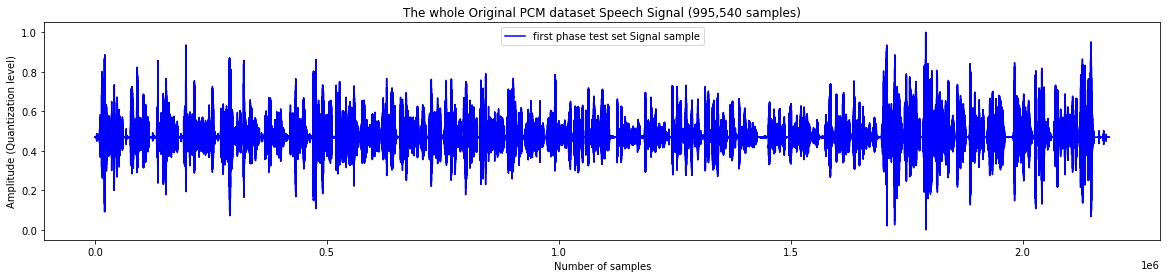

In [12]:
#====================This is a one step forecast (based on that we have constructed the model)====================
plt.figure(figsize=(20, 4))

# Oreginal speech signal data
plt.title('The whole Original PCM dataset Speech Signal (995,540 samples)') 
plt.plot(org_samp[:], 'b', label='first phase test set Signal sample') 
#plt.plot(org_samp[332001:664000], 'g', label='Original Signal sample')

# Predicted speech signal data
plt.xlabel('Number of samples')
plt.ylabel('Amplitude (Quantization level)')
#plt.plot(y_pred, 'g', label='predicted Speech Signal')
plt.legend(loc='upper center')

In [13]:
# to load or run the saved model
from tensorflow.keras.models import load_model
loaded_model=load_model('G_ADPCM_GRU_speech_coding_trained_model_Adam_epoch_50_length_of_step_10.h5')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3)                 54        
                                                                 
 dropout (Dropout)           (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 58
Trainable params: 58
Non-trainable params: 0
_________________________________________________________________


In [14]:
# ===============Step 0: Data Preparation==============
# Need the data to be in the form [sample, time steps, features (dimension of each element)]
samples = 10 # Number of samples (in past)
steps = 1 # Number of steps (in future)
X = [] # X array
Y = [] # Y array

for i in range(wavdata.shape[0] - samples): 
    X.append(pre_samp[i:i+samples]) # Independent Samples
    Y.append(org_samp[i+samples-1]) # Dependent Samples
X = np.array(X)
X = np.expand_dims(X, axis=2)
Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

print('Training Data: Length is ',len(X[0:1][0]),': ', X[0:1])
print('Testing Data: Length is ', len(Y[0:1]),': ', Y[0:1])

print('Dimensions of X:', X.shape) 
print('Dimensions of Y:', Y.shape)

# threshold = round(0.9 * X.shape[0])
# print('Threshold is', threshold)

Training Data: Length is  10 :  [[[0.46758651]
  [0.46764126]
  [0.46758651]
  [0.46753176]
  [0.467477  ]
  [0.46753176]
  [0.46758651]
  [0.46753176]
  [0.46753176]
  [0.46753176]]]
Testing Data: Length is  1 :  [[0.4691338]]
Dimensions of X: (2187064, 10, 1)
Dimensions of Y: (2187064, 1)


Testing Length: (2187064, 10, 1) (2187064, 1)
68346/68346 [==============================] - 162s 2ms/step


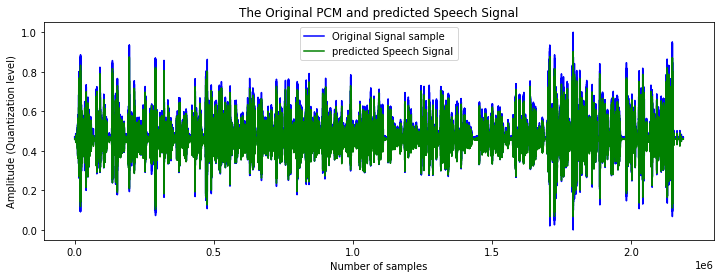

In [15]:
# =========================preparing testing set========================
testX, testY =  X[:], Y[:]
print('Testing Length:',testX.shape, testY.shape)


#====================This is a one step forecast (based on that we have constructed the model)====================
plt.figure(figsize=(12, 4))
y_pred = loaded_model.predict(testX)

# Oreginal speech signal data
plt.title('The Original PCM and predicted Speech Signal') 
plt.plot(testY, 'b', label='Original Signal sample')

# Predicted speech signal data
plt.xlabel('Number of samples')
plt.ylabel('Amplitude (Quantization level)')
plt.plot(y_pred, 'g', label='predicted Speech Signal')
plt.legend(loc='upper center')

In [29]:
# To zoom and view the actual and predicted signal difference plot in between 3000 to 3050 the sample 50 samples
plt.figure(figsize=(12, 4))
# Oreginal speech signal data
#plt.title('The Original PCM and predicted Speech Signal it was randomly taken from 3000th to 3050th') 
plt.plot(testY[1300000-10:1300100-10], 'b', label='Original Signal sample')


# Predicted speech signal data
plt.xlabel('Number of samples')
plt.ylabel('Amplitude (Quantization level)')
plt.plot(y_pred[1300000-10:1300100-10], 'g', label='predict Signal sample')
plt.legend(loc='upper right')
plt.savefig("zoomed onlineRNN-ADPCM_1300000 to 1300100 signal.png", dpi=300)
plt.close()

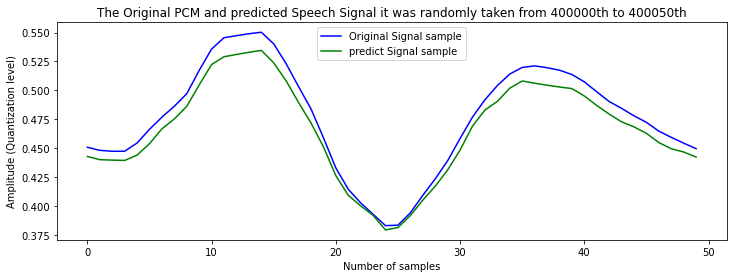

In [28]:
# To zoom and view the actual and predicted signal difference plot in between 3000 to 3050 the sample 50 samples
plt.figure(figsize=(12, 4))
# Oreginal speech signal data
plt.title('The Original PCM and predicted Speech Signal it was randomly taken from 400000th to 400050th') 
plt.plot(testY[400000-5:400050-5], 'b', label='Original Signal sample')


# Predicted speech signal data
plt.xlabel('Number of samples')
plt.ylabel('Amplitude (Quantization level)')
plt.plot(y_pred[400000-5:400045], 'g', label='predict Signal sample')

plt.legend(loc='upper center')

In [ ]:
# To zoom and view the actual and predicted signal difference plot in between 3000 to 3050 the sample 50 samples
plt.figure(figsize=(12, 4))
# Oreginal speech signal data
plt.title('The Original PCM and predicted Speech Signal it was randomly taken from 700000th to 700050th') 
plt.plot(testY[700000-5:700050-5], 'b', label='Original Signal sample')


# Predicted speech signal data
plt.xlabel('Number of samples')
plt.ylabel('Amplitude (Quantization level)')
plt.plot(y_pred[700000-5:700045], 'g', label='predict Signal sample')

plt.legend(loc='upper center')

In [ ]:
#==================error_signal==========================
plt.figure(figsize=(12, 4))
error_signal = testY - y_pred
#print("error_signal:",error_signal)

plt.plot(error_signal, label = 'error_signal')
plt.legend()

In [ ]:
# The actual and predicted signal plot 
plt.figure(figsize=(12, 4))

# Oreginal speech signal data
plt.title('GRU predictor model based ADPCM Actual, predicted and quantization error speech signal') 
plt.plot(testY, 'b', label='Original Signal sample')

# Predicted speech signal data
plt.xlabel('Number of samples')
plt.ylabel('Amplitude (Normalized Quantization level)')
plt.plot(y_pred, 'g', label='predict Signal sample')

# Error signal data
plt.plot(error_signal, 'r', label='Error signal(difference of Actual and predicted)')
plt.legend(loc='upper center')

In [ ]:
# ============= Calculating Signal to Noise Ratio (SNR)===========

error_signal = testY[:332000] - y_pred[:332000]

plt.figure(figsize=(12, 4))
plt.plot(error_signal, 'b')
plt.show()

org_sigpow = 10*np.log10(np.mean(pow(np.abs(testY[:332000]),2)))
error_mse = 10*np.log10(np.mean(pow(np.abs(error_signal),2)))

#print(dnn_mse, dnn_sigpow, lms_mse, lms_sigpow)
print("IMA ADPCM standard SNR:", org_sigpow - error_mse, "dB")